In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [7]:
#データの読み込み
df = pd.read_csv('./temp&hum_2010_2022.csv', index_col=0, parse_dates=True)
df

,temp,hum
2010-01-01,4.8,33.0
2010-01-02,6.3,35.0
2010-01-03,5.7,41.0
2010-01-04,6.5,41.0
2010-01-05,7.3,49.0
...,...,...
2022-12-27,6.8,48.0
2022-12-28,6.5,61.0
2022-12-29,8.1,51.0
2022-12-30,6.6,51.0


In [25]:
#データを週単位に集約
df = df.resample('W').mean()

## 可視化

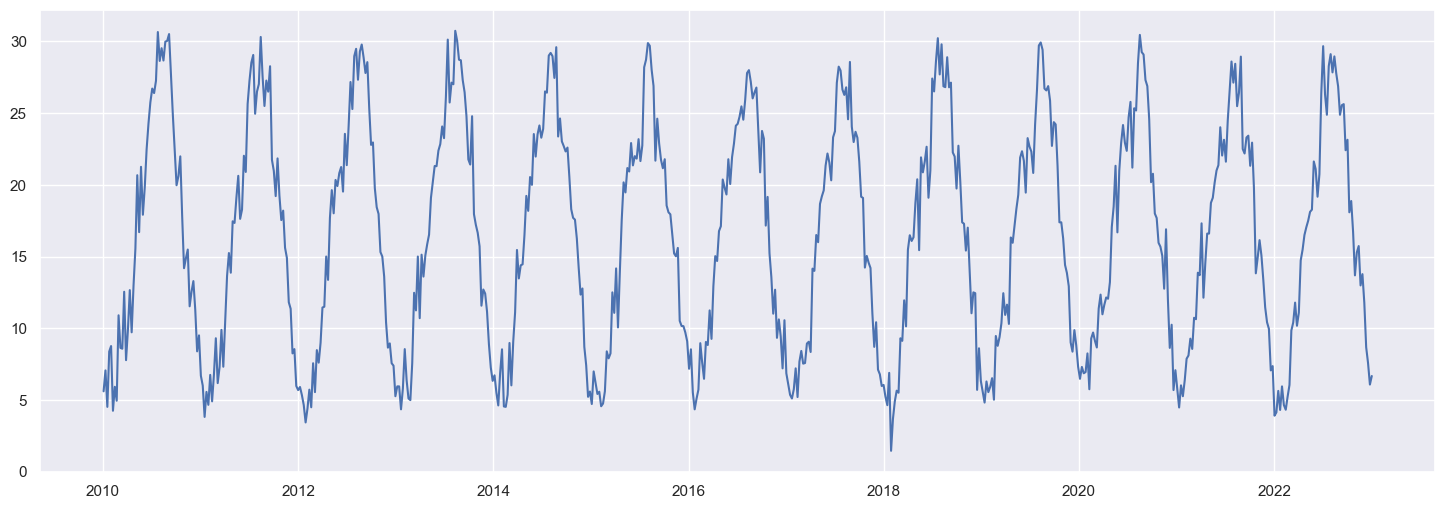

In [29]:
plt.figure(figsize=(18,6))
plt.plot(df['temp'])
plt.show()

定常でありそう。また周期性もある。

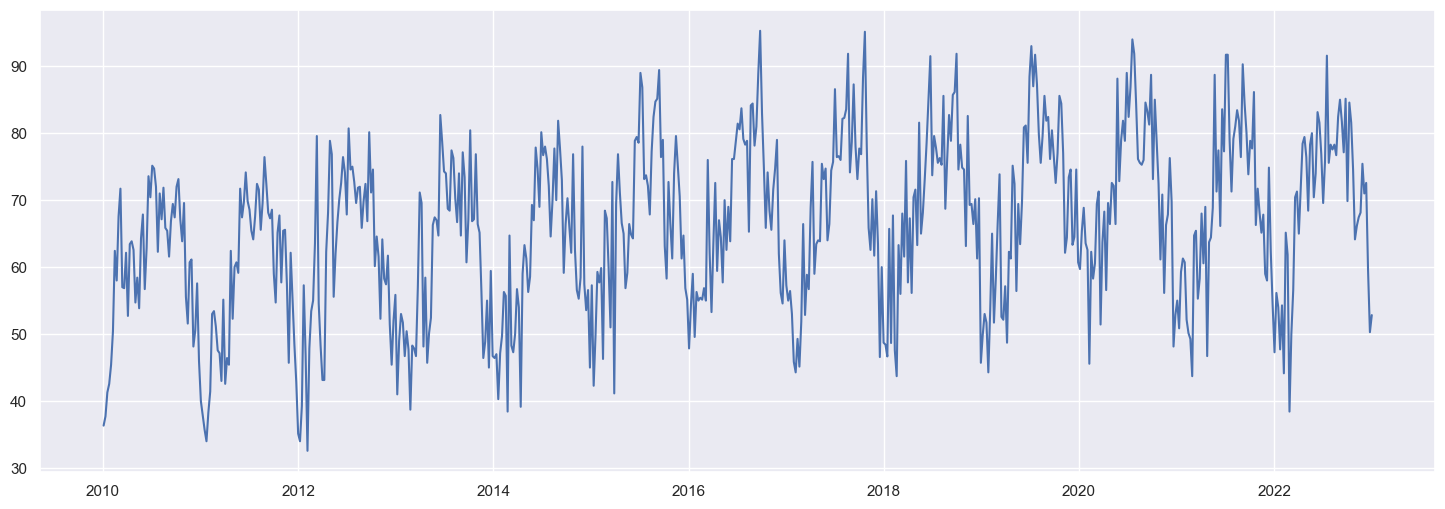

In [28]:
plt.figure(figsize=(18,6))
plt.plot(df['hum'])
plt.show()

気温と同じく周期性はありそうだが、加えて長期的に上昇傾向にあるようにも見える・・・

## 自己相関係数・偏自己相関係数

In [18]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

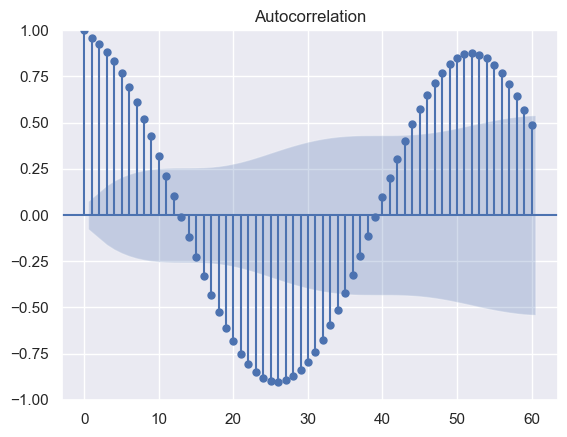

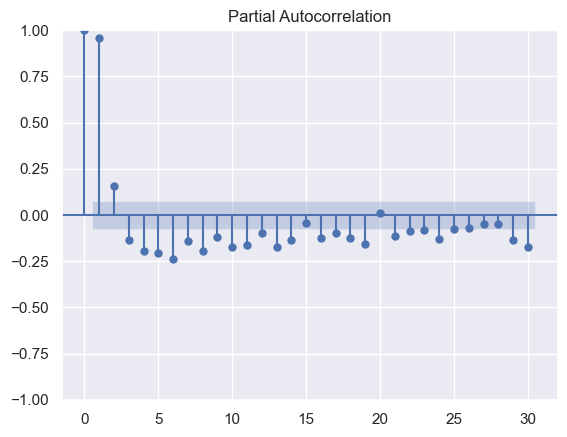

In [33]:
fig_1 = sm.graphics.tsa.plot_acf(df['temp'], lags=60)
fig_2 = sm.graphics.tsa.plot_pacf(df['temp'], lags=30)

自己相関係数を見てみると、予想通り52,3週で相関が高くなっている。

## 波状分解

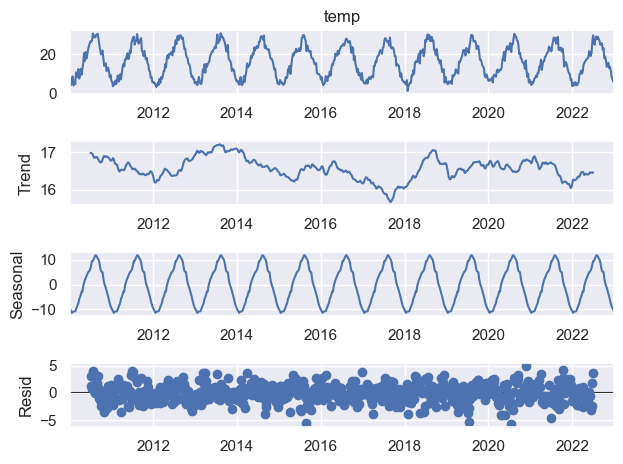

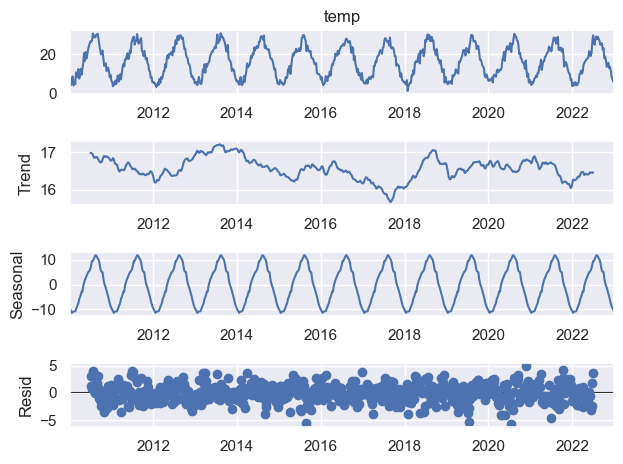

In [36]:
result = seasonal_decompose(df['temp'], period=52, two_sided=True)
result.plot()

## 単位根検定

In [42]:
print('-----------原系列-----------')
nc = sm.tsa.stattools.adfuller(df['temp'], regression='n')
c = sm.tsa.stattools.adfuller(df['temp'], regression='c')
ct = sm.tsa.stattools.adfuller(df['temp'], regression='ct')
ctt = sm.tsa.stattools.adfuller(df['temp'], regression='ctt')

print('nc p-value:' + str(nc[1]))
print('c p-value:' + str(c[1]))
print('ct p-value:' + str(ct[1]))
print('ctt p-value:' + str(ctt[1]))

-----------原系列-----------
nc p-value:0.1460341611371596
c p-value:1.2320297547400729e-21
ct p-value:9.870220450756734e-19
ctt p-value:6.161577335083841e-19


In [38]:
import itertools
p = range(0,2)
d = range(0,2)
q = range(0,2)
pdg = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p,d,q))]

In [40]:
best_param_seasonal = [0,0,0,0]
best_aic = 999999

best_param = (1,1,1)

for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(df['temp'], order=best_param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}365 - AIC:{}'.format(best_param, param_seasonal, results.aic))

        if best_aic > results.aic:
            best_param_seasonal = param_seasonal
            best_aic = results.aic
    
    except:
        continue

print('*BEST ARIMA{}x{}365 - AIC:{}'.format(best_param, best_param_seasonal, best_aic))


ARIMA(1, 1, 1)x(0, 0, 0, 52)365 - AIC:3001.7313117162557
ARIMA(1, 1, 1)x(0, 0, 1, 52)365 - AIC:2724.5325578934508
ARIMA(1, 1, 1)x(0, 1, 0, 52)365 - AIC:2795.06792416591
ARIMA(1, 1, 1)x(0, 1, 1, 52)365 - AIC:2322.976817134746
ARIMA(1, 1, 1)x(1, 0, 0, 52)365 - AIC:2706.757151755832
ARIMA(1, 1, 1)x(1, 0, 1, 52)365 - AIC:2552.3121323795385
ARIMA(1, 1, 1)x(1, 1, 0, 52)365 - AIC:2436.1623135225936
ARIMA(1, 1, 1)x(1, 1, 1, 52)365 - AIC:2322.9294891782265
*BEST ARIMA(1, 1, 1)x(1, 1, 1, 52)365 - AIC:2322.9294891782265
